In [3]:
from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.pyplot.ion()
%matplotlib inline 
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, find_offset, AnnealOffset

from qlp.tdse import (
    s_to_offset,
    AnnealSchedule,
    plot_anneal_schedule,
    TDSE,
    embed_qubo_example,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

-0.05


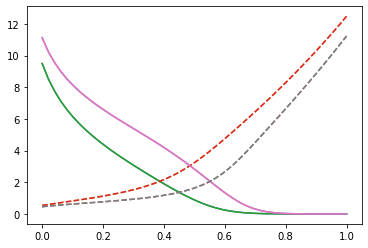

3.1994953815294846


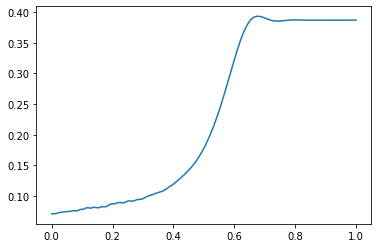

In [6]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = -0.05 * np.arange(1, 2)
for offset_min in offset_min_list:
    print(offset_min)
    nvertices = 2
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2
    embed = False  # nvertices = [2] available

    annealing_time = 0.03  # microseconds set by normalized_time [0, 1]
    normalized_time = [0, 1]  # make larger range for complete offsets

    offset = "binary"
    anneal_curve = "dwave"  # "linear", "logistic" or "dwave".
    fill_value = "extrapolate"  # "extrapolate" or "truncate" the offset. Extrapolate to simulate DWave offset.
    offset_min = offset_min
    offset_range = -2 * offset_min

    solver_params = dict()
    solver_params["method"] = "RK45"
    solver_params["rtol"] = 1e-6
    solver_params["atol"] = 1e-7

    pure_tdse = False
    mixed_tdse = True
    initial_wavefunction = "dwave"  # "true" or "dwave"

    degeneracy_tol = 2e-2  # label energy as degenerate to g.s. if within this fraction

    save_result = True
    """Start Program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    qubo_constant = penalty * nvertices
    # print("QUBO")
    # print(qubo.todense())

    # convert to Ising
    # Jij MUST BE upper triangular
    # This returns a J_ij s_i s_j + h_i s_i Ising model parameterization
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    # print(Jij)
    # print(hi)

    if embed:
        qubo, embedding = embed_qubo_example(nvertices)
        hi_for_offset = np.array(
            [
                hi[key]
                for key in np.sort(list(embedding.keys()))
                for count in range(len(embedding[key]))
            ]
        )
        Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    else:
        hi_for_offset = hi

    # number of qubits
    n = len(qubo.todense())

    #######################################################################################
    # this is the unit conversion of energy/time (since we set time interval to be [0,1])
    #######################################################################################

    # assume annealing_time unit in microsecond and energy unit in Ghz
    def energyscaleconversion(annealing_time):
        return annealing_time * 1000.0 / (2.0 * np.pi)

    energyscale = energyscaleconversion(annealing_time)

    ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}
    offset_params = {
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # print("Ising")
    # print(Jij)
    # print(hi)
    # print(energyscale)

    # plot graph
    # gt.get_plot(graph, directed=directed)
    # plt.show()
    # initial state
    xev = np.asarray([1.0 / np.sqrt(2.0), 1.0 / np.sqrt(2.0)])
    y0 = xev[:]
    for i in range(n - 1):
        y0 = np.kron(xev, y0)
    y0 = (1.0 + 0.0j) * y0  # ensure complex dtype
    # print('initial state',y0)

    # solve ode
    tdse = TDSE(n, ising_params, offset_params)

    # plot anneal schedule
    plot_anneal_schedule(tdse, normalized_time)

    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        # input parameter
        temp = 15E-3 # Kelvins #Dwave is 15E-3
        
        kb = 8.617333262145E-5 # eV / K
        h = 4.135667696E-15 # eV s
        one = 1E-9 #GHz s
        beta = 1 / (temp * kb / h * one) # inverse temperature [h/GHz]
        print(beta)
        #beta=0.1 # inverse temperature [h/GHz]
        # be careful only stable for high temperature 
        # this is just quick and dirty implementation shows how it works
        # need to make this stable for low temperature exp(-beta*H) 

        # construct initial density matrix
        eigvalue, eigvector = eigh(tdse.annealingH(s=normalized_time[0]))
        rho=np.zeros((eigvalue.size*eigvalue.size))
        #print('Ei',eigvalue)
        pr=np.exp(-beta*eigvalue)/sum(np.exp(-beta*eigvalue))
        #print('pr',pr)

        for i in range(eigvalue.size):
            #print(i,eigvector[:,i])
            rho=rho+(pr[i])*np.kron(eigvector[:,i],np.conj(eigvector[:,i]))
        #print('rho',rho)
        rho=(1.+0.j)*rho

        # define time evolution of density matrix
        def annealingH_densitymatrix(s):
            Fockid=np.identity(eigvalue.size)
            return np.kron(tdse.annealingH(s),Fockid)-np.kron(Fockid,tdse.annealingH(s))    

        def f_densitymatrix(t, y):
            """Define time-dependent Schrodinger equation for density matrix"""
            f = -1j * np.dot(annealingH_densitymatrix(t), y)
            return f

        # solve
        sol_densitymatrix = solve_ivp(f_densitymatrix, [0,1], rho)

        #print(sol_densitymatrix.t.size)
        #print(sol_densitymatrix.y[sol_densitymatrix.t.size-1])

        # overlap with Ising ground state
        Isingenergy, Isingeigv = np.linalg.eigh(tdse.IsingH)
        Isinggnd=Isingeigv[:,0]
        project=np.kron(Isinggnd,np.conj(Isinggnd)) 
        prob=np.asarray([np.absolute((np.dot(np.conj(project),sol_densitymatrix.y[:,i]))) for i in range(sol_densitymatrix.t.size)])
        plt.plot(sol_densitymatrix.t,prob)
    
    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################
    
    if pure_tdse:
        if initial_wavefunction == "true":
            # true ground state
            eigvalue, eigvector = eigh(tdse.annealingH(s=normalized_time[0]))
        elif initial_wavefunction == "dwave":
            # DWave initial wave function
            eigvalue, eigvector = eigh(
                -0.5
                * energyscale
                * tdse.constructtransverseH(tdse.AS.A(0) * np.ones(n))
            )
        y1 = (1.0 + 0.0j) * eigvector[:, 0]
        # print("Initial wavefunction")
        # print(y1)

        # solve
        ngrid = 11
        interval = np.linspace(normalized_time[0], normalized_time[1], ngrid)
        # print(interval)
        class sol_interface:
            def __init__(self):
                self.t = np.zeros((0))
                self.y = np.zeros((y1.size, 0))

        sol = sol_interface()

        for jj in range(ngrid - 1):
            y1 = y1 / (np.sqrt(np.absolute(np.dot(np.conj(y1), y1))))
            tempsol = solve_ivp(
                tdse, [interval[jj], interval[jj + 1]], y1, **solver_params
            )
            y1 = tempsol.y[:, tempsol.t.size - 1]
            # print(np.shape(sol.t))
            # print(np.shape(tempsol.t))

            sol.t = np.hstack((sol.t, tempsol.t))

            # print(sol.y)
            # print(np.shape(tempsol.y))

            sol.y = np.hstack((sol.y, tempsol.y))

        print(
            "final total prob",
            np.sqrt(np.absolute(np.dot(np.conj(sol.y[:, -1]), sol.y[:, -1]))),
        )
        # end renormalize...

        # print('ode solution')
        # for i in range(sol.t.size):
        #    print('time',i,'=',sol.t[i])
        #    print(sol.y[:,i])

        # brute force diagonalization Ising hamiltonain

        energy, eigv = np.linalg.eigh(tdse.IsingH)
        mask = [abs((ei - energy[0]) / energy[0]) < degeneracy_tol for ei in energy]
        print(f"Num. degenerate states @ s={normalized_time[1]}: {np.sum(mask)}")
        ground_state_idx = np.arange(len(energy))[mask]
        # print('brute force Ising')
        # print('eigen envergy',energy)
        # print('eigen vector')
        # print(eigv)

        # plot probability overlap with Ising ground state
        overlap = np.zeros(sol.t.size)
        overlap_annealH = np.zeros(sol.t.size)
        degen_number = np.zeros(sol.t.size)
        for i, t in enumerate(sol.t):
            # overlap with target Hamiltonian ground state
            overlap[i] = sum(
                np.absolute(
                    [np.dot(np.conj(eigv[:, idx]), sol.y[:, i]) for idx in ground_state_idx]
                )
                ** 2
            )
            # overlap with time-dependent Hamiltonian ground state
            eigval_annealH, eigv_annealH = eigh(tdse.annealingH(s=t))
            mask_annealH = [abs((ei - eigval_annealH[0]) / eigval_annealH[0]) < degeneracy_tol for ei in eigval_annealH]
            degen_number[i] = sum(mask_annealH)
            annealH_gs_idx = np.arange(len(eigval_annealH))[mask_annealH]
            overlap_annealH[i] = sum(
            np.absolute(
                    [np.dot(np.conj(eigv_annealH[:, idx]), sol.y[:, i]) for idx in annealH_gs_idx]
                )
            ) / np.sqrt(degen_number[i])
            
        if save_result:
            with open(
                f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
                "wb",
            ) as file:
                rpickle = dict()
                rpickle["tdse"] = tdse
                rpickle["sol"] = sol
                rpickle["overlap"] = overlap
                rpickle["overlap_annealH"] = overlap_annealH
                rpickle["degen_number"] = degen_number
                pickle.dump(rpickle, file)

In [ ]:
result = dict()
proba = dict()
proba_annealH = dict()
degen_number = dict()
plt.figure("prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    with open(f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle", "rb") as file:
        rpickle = pickle.load(file)
        offset_range = -2*offset_min
        result[offset_range] = rpickle["tdse"]
        proba[offset_range] = rpickle["overlap"][-1]
        proba_annealH[offset_range] = rpickle["overlap_annealH"][-1]
        degen_number[offset_range] = rpickle["degen_number"]
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | gnd >|^2$')
plt.title('Probability of reaching Ising ground state')
plt.show()

plt.figure("annealH prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap_annealH"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | \psi_0(s) >|^2$')
plt.title('Probability of wavefunction in H(s) ground-state')
plt.show()

plt.figure("degeneracy number")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["degen_number"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'ground-state degeneracy')
plt.show()

plt.figure("prob final")
ax=plt.axes()
ax.errorbar(x=list(proba.keys()), y=list(proba.values()), marker="o")
ax.set_xlabel('offset range')
ax.set_ylabel('s=1 probability')
plt.title(offset)
plt.show()

# plot last anneal schedule
plt.figure()
ax = plt.axes()
X = np.linspace(*normalized_time)
yA = np.array([tdse.AS.A(Xi) for Xi in X])
yB = np.array([tdse.AS.B(Xi) for Xi in X])
for qubit in range(len(yA[0])):
    ax.errorbar(x=X, y=yA[:, qubit])
    ax.errorbar(x=X, y=yB[:, qubit], ls='--')

In [ ]:
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1/energyscale * 1/tdse.AS.B(normalized_time[1])[0]

fig = plt.figure()
ax = plt.axes()
num_es = 10
gap = dict()
for key in result.keys():
    x = []
    y = {es: [] for es in range(num_es)}
    for s in np.linspace(normalized_time[0], normalized_time[1]):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = np.sort(eigval)*make_dimensionless + ising_params['c'] + qubo_constant
        x.append(s)
        for es in y.keys():
            y[es].append(seigval[es])
    for es in y.keys():
        ax.errorbar(x=x, y=y[es])
    gap[key] = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh(result[key].annealingH(s))
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))


In [ ]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    for es in gap[key].keys():
        ax.errorbar(x=x, y=gap[key][es], label=es)
#ax.legend()
plt.draw()
plt.show()
print(f"e1-e0 gap[offset_range={min(gap.keys())}][{sum(mask)}]:", gap[min(gap.keys())][sum(mask)][-1])
print(f"e2-e0 gap[offset_range={min(gap.keys())}][{sum(mask)+1}]:", gap[min(gap.keys())][sum(mask)+1][-1])

In [ ]:
mingap = {key: min(gap[key][1]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y = list(mingap.values())
ax.errorbar(x=x, y=y, marker="o")
plt.draw()
plt.show()
mingap

In [ ]:
sol.t